# Atlantic-Eq Mode Study

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.ticker as ticker
from netCDF4 import Dataset as ncread
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random
from tabulate import tabulate
import pandas as pd
import xarray as xr
import warnings


In [2]:
path = 'E:/TFG/Datos/Importants/'
data1 = path+'HadISST_sst_v1.1_196001_202105.nc'#database_a: HadISST (Hadley Centre Sea Ice and Sea Surface Temperature dataset) de 1960-2021, 1°x1°
data2 = path+'sst.mnmean_v5_196001_202105.nc'   #database_b: ERSST (Extended Reconstructed SST), 2°x2° from NOAA
data3 = path+'noaa.pcp.mon.anom_196001_202105.nc' #datobase1: NOAA (National Oceanic and Atmospheric Administration ), 1.875°x2° 
data4 = path+'pcp.mon.ncep-ncar_196001_202105.nc' #datobase2: NCEP-NCAR, 2.5°x2.5°
#Retrieve data
nc1 = ncread(data1, 'r')  #sst
nc2 = ncread(data2, 'r')  #sst
nc3 = ncread(data3, 'r')  #prec
nc4 = ncread(data4, 'r')  #prec
#vamos a ver las variables que tenemos que llamar de cada archivo

print("nc1:", list(nc1.variables.keys()))
print("nc2:", list(nc2.variables.keys()))
print("nc3:", list(nc3.variables.keys()))
print("nc4:", list(nc4.variables.keys()))  

nc1: ['latitude', 'longitude', 'sst', 'time', 'time_bnds']
nc2: ['lat', 'lon', 'sst', 'time', 'time_bnds']
nc3: ['lat', 'lon', 'precip', 'time']
nc4: ['lat', 'lon', 'prate', 'time']


Las keys indican que palabra clave esta asociada a cada dato según cada base de dato

In [3]:
data_files = {"HadISST": data1,"ERSST": data2,"NOAA PCP": data3,"NCEP-NCAR": data4}

# Función para extraer info de los datos, resolución, rango, etc
def ex_info(file_path):
    
    nc = ncread(file_path, "r")  # Abrir archivo NetCDF

     # Verificamos cómo están nombradas las variables de latitud y longitud
    lat_name = next(var for var in nc.variables.keys() if "lat" in var.lower())  #next devuele el primer elemento del iterador 
    lon_name = next(var for var in nc.variables.keys() if "lon" in var.lower())  #util porque no queremos una lista de 1 elemento queremos el string
                                                                                     #lat_name[0] tambien devuelve el primero pero el next te evita
    latitudes = nc.variables[lat_name][:]                                        #crear la lista, es mas eficiente
    longitudes = nc.variables[lon_name][:]

    # Rango de latitud y longitud
    lat_range = (latitudes.min(), latitudes.max())
    lon_range = (longitudes.min(), longitudes.max())

    # Resolución (suponemos que la diferencia entre dos puntos consecutivos es la resolución)
    lat_res = round(abs(latitudes[1] - latitudes[0]),3)
    lon_res = round(abs(longitudes[1] - longitudes[0]),3)

    nc.close()  # Cerrar el archivo para liberar memoria
    return (lat_res, lon_res), lat_range, lon_range

# Crear la tabla con los datos extraídos
table = []
for name, path in data_files.items(): #Este bucle recorre cada par (nombre, ruta) del diccionario.
    info = ex_info(path)  #Pathh en este contexto seria el segundo numero de la dupla es decir data1,data2,etc
    if info:
        table.append([name, *info]) #con el * desempacamos la tupla y la tabla es [HadISST, (1,2),(3,4),(5,6)] y no [HadISST,[(1,2),(3,4),(5,6)]]
        
# Crear DataFrame
columns = ["Base de datos", "Resolución (lat, lon)", "Rango de latitud", "Rango de longitud",]
df_table = pd.DataFrame(table, columns=columns)
df_table = df_table.set_index("Base de datos")


# Hacemos bonita la tabla
df_table["Rango de latitud"] = df_table["Rango de latitud"].apply(lambda x: f"({round(float(x[0]), 2)}°, {round(float(x[1]), 2)}°)")
df_table["Rango de longitud"] = df_table["Rango de longitud"].apply( lambda x: f"({round(float(x[0]), 2)}°, {round(float(x[1]), 2)}°)")
df_table["Resolución (lat, lon)"] = df_table["Resolución (lat, lon)"].apply(lambda x: f"({round(float(x[0]), 3)}°, {round(float(x[1]), 3)}°)")

print(tabulate(df_table, headers="keys", tablefmt="pretty"))




+---------------+-----------------------+-------------------+-------------------+
| Base de datos | Resolución (lat, lon) | Rango de latitud  | Rango de longitud |
+---------------+-----------------------+-------------------+-------------------+
|    HadISST    |     (1.0°, 1.0°)      |  (-89.5°, 89.5°)  | (-179.5°, 179.5°) |
|     ERSST     |     (2.0°, 2.0°)      |  (-88.0°, 88.0°)  |  (0.0°, 358.0°)   |
|   NOAA PCP    |     (2.5°, 2.5°)      | (-88.75°, 88.75°) | (1.25°, 358.75°)  |
|   NCEP-NCAR   |   (1.889°, 1.875°)    | (-88.54°, 88.54°) |  (0.0°, 358.12°)  |
+---------------+-----------------------+-------------------+-------------------+


Esta tabla es necessaria para saber gestionar cada base de datos, es una guía que se usa para escoger cada conjunto de rangos de datos.

HadISST:   (ny_a, ni_a)         = (180, 360)
ERSST:     (ny_b, ni_b)         = (89, 180)
NOAAPCP:   (ny_pcp, ni_pcp)     = (72, 144)
NCEP-NCAR: (ny_pcp2, ni_pcp2)   = (94, 192)
Forma HadISST: (732, 180, 360)
Forma ERSST: (732, 89, 180)


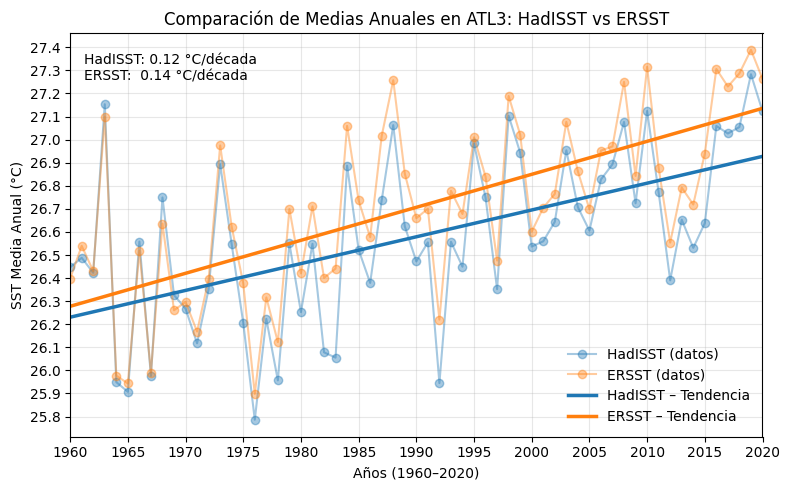

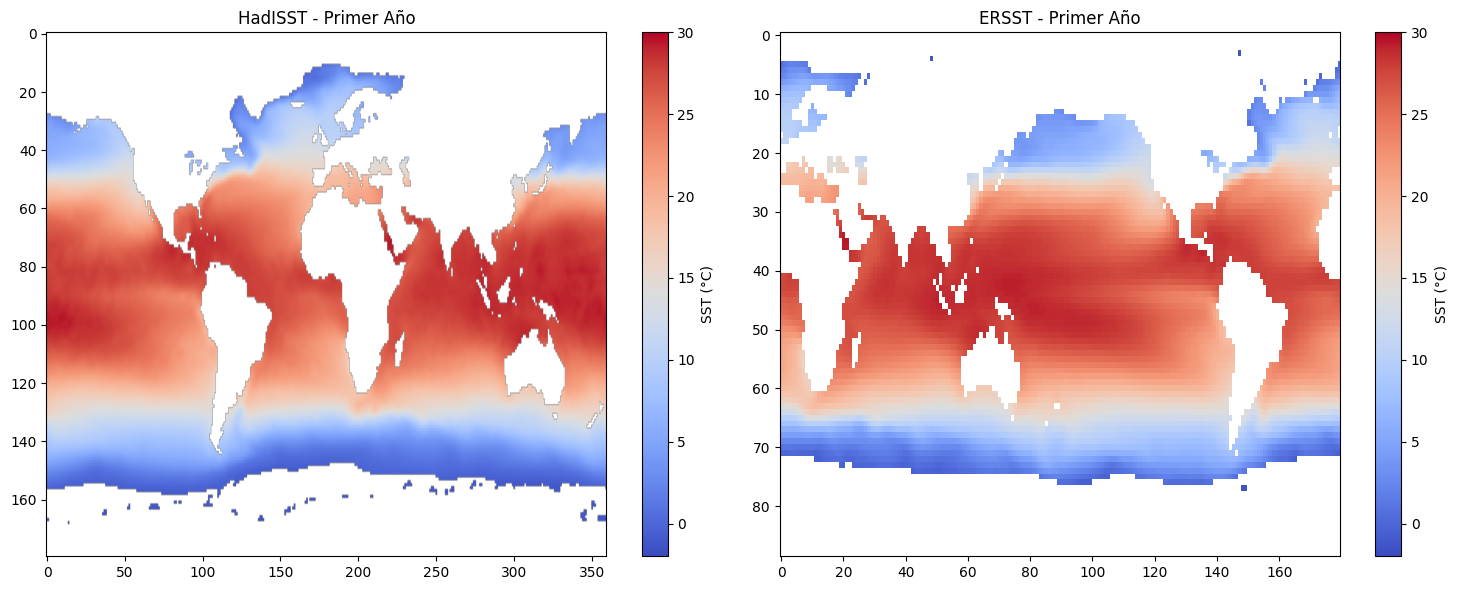

In [16]:
#Entendemos nuestros datos:
sst_a = nc1.variables['sst'][:732] #HadISST: R=1°x1°,
sst_b = nc2.variables['sst'][:732] #ERSSTD:  R=2°x2°   
pcp = nc3.variables['precip'][:732] #NOAA PCP:  R=2.5°x2.5°
pcp2 = nc4.variables['prate'][:732] #NCEP-NCAR:  R=1.889°x1.875°

def lat_lon(file_path): #funcion para retornar long y lat en funcion de la data
    nc = ncread(file_path, "r")
    lat_name = next(var for var in nc.variables.keys() if "lat" in var.lower()) #busca el nombre asociado las coordenadas
    lon_name = next(var for var in nc.variables.keys() if "lon" in var.lower()) #suponemos que contiene lat/lon
    longitudes = nc.variables[lon_name][:]
    latitudes = nc.variables[lat_name][:]                                        
    nc.close()
    return longitudes, latitudes
    
lon_a, lat_a  = lat_lon(data1)
lon_b, lat_b  = lat_lon(data2)
lon_pcp, lat_pcp  = lat_lon(data3)
lon_pcp2, lat_pcp2  = lat_lon(data4)

nt = len(sst_a[:,0,0])
nyr = int(nt/12) 
ny_a = len(lat_a)
ni_a = len(lon_a)   # al haber diferentes resoluciones el numeros de lat y longitud varia asi que mejor mirar todas
ny_b = len(lat_b) 
ni_b = len(lon_b)
ny_pcp = len(lat_pcp)
ni_pcp = len(lon_pcp)
ny_pcp2 = len(lat_pcp2)
ni_pcp2 = len(lon_pcp2)

print("HadISST:   (ny_a, ni_a)         = (" + str(ny_a) + ", " + str(ni_a) + ")")
print("ERSST:     (ny_b, ni_b)         = (" + str(ny_b) + ", " + str(ni_b) + ")")
print("NOAAPCP:   (ny_pcp, ni_pcp)     = (" + str(ny_pcp) + ", " + str(ni_pcp) + ")")
print("NCEP-NCAR: (ny_pcp2, ni_pcp2)   = (" + str(ny_pcp2) + ", " + str(ni_pcp2) + ")")
print(f"Forma HadISST: {(sst_a).shape}")
print(f"Forma ERSST: {(sst_b).shape}")

sst_a = np.where(sst_a <= -1.79, np.nan, sst_a)  # SST oceánica no baja de -1.8°C
sst_a = np.where(sst_a > 40, np.nan, sst_a)    # SST oceánica no sube de ~35°C
sst_b = np.where(sst_b <= -1.79, np.nan, sst_b)  # SST oceánica no baja de -1.8°C
sst_b = np.where(sst_b > 40, np.nan, sst_b)    # SST oceánica no sube de ~35°C

# Calcular medias anuales (732 meses = 61 años)
sst_a_annual = sst_a.reshape(61, 12, *sst_a.shape[1:]).mean(axis=1)
sst_b_annual = sst_b.reshape(61, 12, *sst_b.shape[1:]).mean(axis=1)

Temp_ATL3_a = []
Temp_ATL3_b = []

for i in range(61):
    matriuATL3_a = sst_a_annual[i, 86:94, 160:180]      # HadISST
    Temp_ATL3_a.append(np.mean(matriuATL3_a))

    matriuATL3_b = sst_b_annual[i, 42:47, 170:180]      # ERSST
    Temp_ATL3_b.append(np.mean(matriuATL3_b))
Temp_ATL3_a = np.array(Temp_ATL3_a)
Temp_ATL3_b = np.array(Temp_ATL3_b)

# Tendencias lineales
years=(np.arange(1960, 2021, 1))
coef_a = np.polyfit(years, Temp_ATL3_a, 1)
coef_b = np.polyfit(years, Temp_ATL3_b, 1)

trend_a = np.polyval(coef_a, years)
trend_b = np.polyval(coef_b, years)
slope_a = coef_a[0]          # °C/año
slope_b = coef_b[0]
slope_a_dec = slope_a * 10
slope_b_dec = slope_b * 10

# Crear gráfica 
# Crear gráfica 
plt.figure(figsize=(8, 5))
plt.plot(years, Temp_ATL3_a, 'o-', label='HadISST (datos)', color='C0', alpha=0.4)
plt.plot(years, Temp_ATL3_b, 'o-', label='ERSST (datos)', color='C1',alpha=0.4)
plt.plot(years, trend_a, label='HadISST – Tendencia', color='C0',lw=2.5)
plt.plot(years, trend_b, label='ERSST – Tendencia', color='C1',lw=2.5)


plt.xlabel('Años (1960–2020)')
plt.ylabel('SST Media Anual (°C)')
plt.title('Comparación de Medias Anuales en ATL3: HadISST vs ERSST')

plt.xlim(1960, 2020)
plt.xticks(np.arange(1960, 2021, 5))

ymin = np.floor(min(Temp_ATL3_a.min(), Temp_ATL3_b.min()) * 10) / 10
ymax = np.ceil (max(Temp_ATL3_a.max(), Temp_ATL3_b.max()) * 10) / 10
plt.yticks(np.arange(ymin, ymax + 0.1, 0.1))  # ← paso 0.1

plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.text(
    0.02, 0.95,
    f"HadISST: {slope_a_dec:.2f} °C/década\nERSST:  {slope_b_dec:.2f} °C/década",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top"
)
plt.tight_layout()
plt.margins(y=0.046)
plt.show()

# Primer mes de HadISST y ERSST
plt.figure(figsize=(15, 6))

# HadISST
plt.subplot(1, 2, 1)
plt.imshow(sst_a_annual[0], cmap='coolwarm', vmin=-2, vmax=30, aspect='auto')
plt.colorbar(label='SST (°C)')
plt.title('HadISST - Primer Año')

# ERSST
plt.subplot(1, 2, 2)
plt.imshow(sst_b_annual[0], cmap='coolwarm', vmin=-2, vmax=30, aspect='auto')
plt.colorbar(label='SST (°C)')
plt.title('ERSST - Primer Año')

plt.tight_layout()
plt.show()




La primera grafica sirve para comparar las medias anuales de las dos fuentes de datos en España, en el mapa vemos lo mismo pero para el primer año y en todo el mundo. Los datos son muy dispersos debido a que año a año el clima no parecen tener sentido vemos que la tendencia es creciente por el calentamiento global y la diferencia entre las dos fuentes de datos año a año es de menos de 0.5°C, vemos que las temperaturas son   

Tuve problemas al inicio al calcular la media en Hadisst porque esta base de datos tiene más datos de tierra y estos contienen valores que estropean la media, convertí esos valores en NAN (35.5% para Hadisst) y soluciono el problema.

Para Errst tambien converti esos valores en (NAN 31.4% para ERSST) pero sus medias no eran muy distintas porque su % de tierra era menos y sobretodo porque esos valores de tierra no eran muy distintos a los de la superficie del mar.

Para calcular las anomalias vamos a restaurar los datos con valores de tierra para evitar tener valores vacios, como trabajaremos sobre anomalias esos valores se eliminan y son irrelevantes.


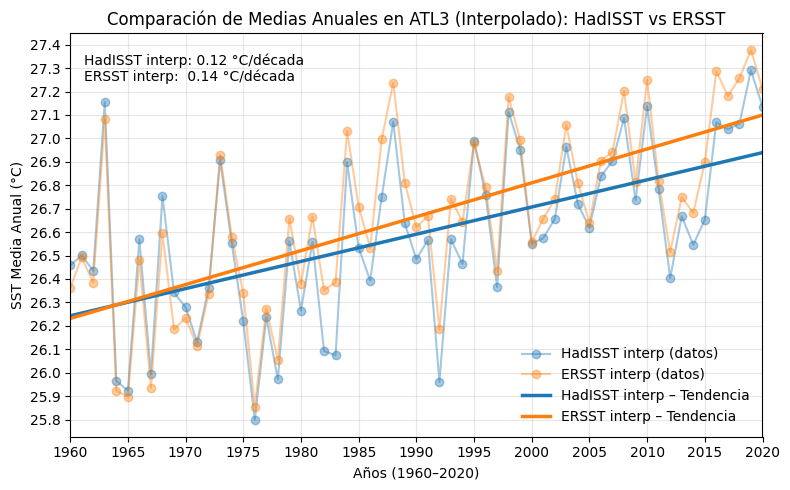

[-4.   -3.75 -3.5  -3.25 -3.  ] ... [3.   3.25 3.5  3.75 4.  ]
[-20.   -19.75 -19.5  -19.25 -19.  ] ... [-1.   -0.75 -0.5  -0.25  0.  ]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# --- Helpers ---
def lon_to_180(lon):
    """Convierte longitudes a rango [-180, 180)."""
    lon = np.array(lon, dtype=float)
    lon = ((lon + 180) % 360) - 180
    return lon

def _ensure_increasing(lat, lon, field2d):
    """
    Asegura que lat y lon estén en orden creciente.
    Reordena field2d en consecuencia.
    """
    lat = np.array(lat)
    lon = np.array(lon)

    # Ordenar lat
    if lat[0] > lat[-1]:
        lat = lat[::-1]
        field2d = field2d[::-1, :]

    # Ordenar lon
    lon_sort_idx = np.argsort(lon)
    lon = lon[lon_sort_idx]
    field2d = field2d[:, lon_sort_idx]

    return lat, lon, field2d

def interp2d_to_target(lat_src, lon_src, field2d, lat_t, lon_t):
    """
    Interpola un campo 2D (lat, lon) a una malla objetivo (lat_t, lon_t).
    """
    lat_src, lon_src, field2d = _ensure_increasing(lat_src, lon_src, field2d)

    interp = RegularGridInterpolator(
        (lat_src, lon_src),
        field2d,
        method="linear",
        bounds_error=False,
        fill_value=np.nan
    )

    LonT, LatT = np.meshgrid(lon_t, lat_t)
    pts = np.column_stack([LatT.ravel(), LonT.ravel()])
    out = interp(pts).reshape(len(lat_t), len(lon_t))
    return out

def area_weighted_mean(field2d, lat_t):
    """Media ponderada por cos(lat) ignorando NaN."""
    w = np.cos(np.deg2rad(lat_t))[:, None]  # (nlat, 1)
    m = np.isfinite(field2d)
    if not np.any(m):
        return np.nan
    return np.nansum(field2d * w) / np.nansum(w * m)

# --- 1) Definir ATL3 por coordenadas (en -180..180) ---
lat_min, lat_max = -4, 4
lon_min, lon_max = -20, 0

# Malla objetivo "fina" (elige resolución; 0.25° suele ir bien)
ddeg = 0.25
lat_t = np.arange(lat_min, lat_max + 1e-9, ddeg)
lon_t = np.arange(lon_min, lon_max + 1e-9, ddeg)

# --- 2) Asegurar convenciones de longitud coherentes ---
lon_a_180 = lon_to_180(lon_a)      # HadISST ya suele estar en -180..180, pero lo normalizamos igual
lon_b_180 = lon_to_180(lon_b)      # ERSST (0..360) -> (-180..180)

# --- 3) Calcular series interpoladas ---
Temp_ATL3_a_intr = np.empty(61)
Temp_ATL3_b_intr = np.empty(61)

for i in range(61):
    # Interpolar HadISST anual i a la malla objetivo
    fld_a = interp2d_to_target(lat_a, lon_a_180, sst_a_annual[i, :, :], lat_t, lon_t)
    Temp_ATL3_a_intr[i] = area_weighted_mean(fld_a, lat_t)

    # Interpolar ERSST anual i a la malla objetivo
    fld_b = interp2d_to_target(lat_b, lon_b_180, sst_b_annual[i, :, :], lat_t, lon_t)
    Temp_ATL3_b_intr[i] = area_weighted_mean(fld_b, lat_t)

# --- 4) Replicar tu bloque de tendencias + figura ---
years = np.arange(1960, 2021, 1)

coef_a = np.polyfit(years, Temp_ATL3_a_intr, 1)
coef_b = np.polyfit(years, Temp_ATL3_b_intr, 1)

trend_a = np.polyval(coef_a, years)
trend_b = np.polyval(coef_b, years)

slope_a_dec = coef_a[0] * 10
slope_b_dec = coef_b[0] * 10

plt.figure(figsize=(8, 5))
plt.plot(years, Temp_ATL3_a_intr, 'o-', label='HadISST interp (datos)', color='C0', alpha=0.4)
plt.plot(years, Temp_ATL3_b_intr, 'o-', label='ERSST interp (datos)', color='C1', alpha=0.4)
plt.plot(years, trend_a, label='HadISST interp – Tendencia', color='C0', lw=2.5)
plt.plot(years, trend_b, label='ERSST interp – Tendencia', color='C1', lw=2.5)

plt.xlabel('Años (1960–2020)')
plt.ylabel('SST Media Anual (°C)')
plt.title('Comparación de Medias Anuales en ATL3 (Interpolado): HadISST vs ERSST')

plt.xlim(1960, 2020)
plt.xticks(np.arange(1960, 2021, 5))

ymin = np.floor(min(np.nanmin(Temp_ATL3_a_intr), np.nanmin(Temp_ATL3_b_intr)) * 10) / 10
ymax = np.ceil (max(np.nanmax(Temp_ATL3_a_intr), np.nanmax(Temp_ATL3_b_intr)) * 10) / 10
plt.yticks(np.arange(ymin, ymax + 0.1, 0.1))

plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.text(
    0.02, 0.95,
    f"HadISST interp: {slope_a_dec:.2f} °C/década\nERSST interp:  {slope_b_dec:.2f} °C/década",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top"
)
plt.tight_layout()
plt.margins(y=0.046)
plt.show()


In [11]:
# redefinimos 
sst_a = nc1.variables['sst'][:732] #HadISST: R=1°x1°
sst_b = nc2.variables['sst'][:732] #ERSST:  R=2°x2°   

def to_float_nan(a):
    """Convierte Variable/MaskedArray a ndarray float con NaNs donde haya máscara."""
    if np.ma.isMaskedArray(a):
        return np.ma.filled(a, np.nan).astype(float)
    return np.array(a, dtype=float)

def calc_monthly_anoms(fen, detrend=True):
    """
    fen: (time, lat, lon) mensual
    return: anoms (year, month, lat, lon)
    """
    arr = to_float_nan(fen)

    # Si viniera 4D (time, level, lat, lon), toma level 0
    if arr.ndim == 4:
        arr = arr[:, 0, :, :]
    if arr.ndim != 3:
        raise ValueError(f"Se esperaba (time, lat, lon), pero llegó {arr.shape}")

    nt, ny, nx = arr.shape
    nyr = nt // 12
    nt_use = nyr * 12
    dat = arr[:nt_use].copy()

    # Detrend (estable): ajusta con NaNs rellenados, resta solo donde hay dato
    if detrend:
        x = np.arange(nt_use)
        X = np.column_stack([x, np.ones(nt_use)])          # (nt, 2)
        Y = dat.reshape(nt_use, -1)                        # (nt, ngrid)
        Yf = np.nan_to_num(Y, nan=0.0)                     # para que lstsq no reviente

        coeffs = np.linalg.lstsq(X, Yf, rcond=None)[0]     # (2, ngrid)
        trend = (X @ coeffs).reshape(dat.shape)            # (nt, ny, nx)

        mask = np.isfinite(dat)
        dat[mask] = dat[mask] - trend[mask]

    # Climatología mensual y anomalías
    dat4 = dat.reshape(nyr, 12, ny, nx)                    # (year, month, lat, lon)
    clim = np.nanmean(dat4, axis=0)                        # (month, lat, lon)
    anoms = dat4 - clim[None, :, :, :]                     # (year, month, lat, lon)
    return anoms
            
#calculem les anomalies dels 4 casos, fem reshape
anoms_a = calc_monthly_anoms(sst_a, detrend=True)
anoms_b = calc_monthly_anoms(sst_b, detrend=True)
anoms_pcp = calc_monthly_anoms(pcp, detrend=True)
anoms_pcp2 = calc_monthly_anoms(pcp2, detrend=True)

print("Anomalies Shape:")
print(f"HadISST:   {anoms_a.shape}")
print(f"ERSST:     {anoms_b.shape}")
print(f"NOAAPCP:   {anoms_pcp.shape}")
print(f"NCEP-NCAR: {anoms_pcp2.shape}")



warnings.filterwarnings(
    "ignore",
    message=r"Mean of empty slice",
    category=RuntimeWarning
)


C:\Users\34679\AppData\Local\Temp\ipykernel_8728\1370474199.py:44: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(dat4, axis=0)                        # (month, lat, lon)


Anomalies Shape:
HadISST:   (61, 12, 180, 360)
ERSST:     (61, 12, 89, 180)
NOAAPCP:   (61, 12, 72, 144)
NCEP-NCAR: (61, 12, 94, 192)


In [12]:
#Monthly Varability over 61 years
var_a= np.nanstd(anoms_a, axis=0)
var_b= np.nanstd(anoms_b, axis=0)
var_pcp= np.nanstd(anoms_pcp, axis=0)
var_pcp2= np.nanstd(anoms_pcp2, axis=0)

variacion_mensual_ATL3_a= []  #para el ATL3
variacion_mensual_Niño_a= [] #para el Niño3.4
variacion_mensual_ATL3_b= []  #para el ATL3
variacion_mensual_Niño_b= [] #para el Niño3.4

for i in range(12):   #calculem la variació estandar en les regions concretes on ocurren els fenomens 
    
   matriu = var_a[i, 86:94, 160:180] # Seleccionamos las coordenas de la matriu (4S-4N,20W-0E)
   variacion_mensual_ATL3_a.append(np.mean(matriu)) # Agrega el valor medio de cada matriz del mes i a la lista
   
   matriu = var_a[i, 84:96, 10:60] # Seleccionamos las coordenas de la matriu (6S-6N,170W-120W)
   variacion_mensual_Niño_a.append(np.mean(matriu))
   
   matriu = var_b[i, 42:47, 170:180] #(4S-4N,20W-0E)
   variacion_mensual_ATL3_b.append(np.mean(matriu)) 
   
   matriu = var_b[i, 41:47, 95:120] #(6S-6N,170W-120W)
   variacion_mensual_Niño_b.append(np.mean(matriu))


warnings.filterwarnings(
    "ignore",
    message=r"Degrees of freedom <= 0 for slice",
    category=RuntimeWarning
)


C:\Users\34679\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Las dos bases de datos en latitud van de -88 a 88 en ERRST, y de -89.5 a 89.5 en HadISST, en longitud son más complejas:
      
Para HadISST los datos de longitud van de -179.5 a 179.5 en ese orden:
   

        -180°               0°              180° 
           |----------------|----------------|
                        Greenwich    
                        
Longitud ERSST van de 0 a 358 para y van en ese  orden:

           0°               180°              360° (= 0° otra vez)
           |----------------|----------------|
        Greenwich     Océano Pacífico     Greenwich otra vez    

En Hadisst es bastante evidente, pero en ERSST tienes que saber que el 0 es Greenwich o tendras problemas al delimitar areas.        

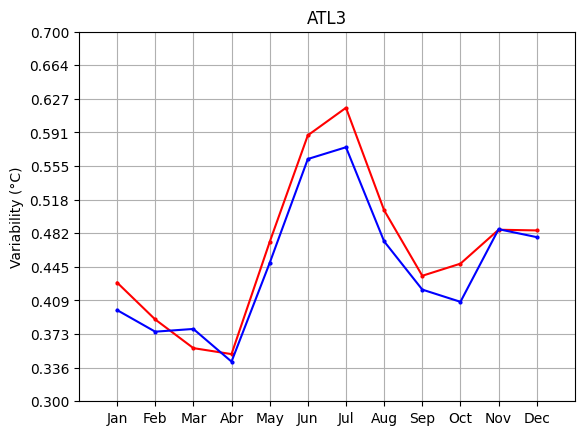

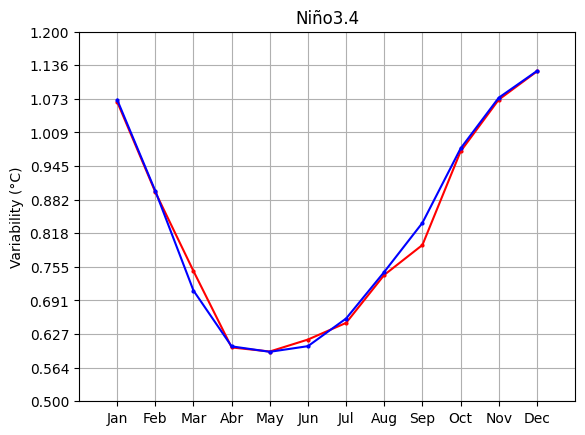

3.5 -3.5 -19.5 -0.5
4.0 -4.0 340.0 356.0


In [17]:
# Mostrar el gráfico
plt.show()
meses = ['Jan','Feb','Mar','Abr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.plot(meses, variacion_mensual_ATL3_a,'-ro', markersize=2)
plt.plot(meses, variacion_mensual_ATL3_b,'-bo', markersize=2)
plt.grid() # Agrega un fondo cuadriculado al gráfico
plt.xlabel('') 
plt.ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
plt.title('ATL3') 
plt.yticks(np.linspace(0.3, 0.7, 12)) # Establece 9 divisiones en el eje y
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
plt.margins(x=0.0909)

plt.show(block=False) 

plt.plot(meses, variacion_mensual_Niño_a,'-ro', markersize=2)
plt.plot(meses, variacion_mensual_Niño_b,'-bo', markersize=2)
plt.grid() # Agrega un fondo cuadriculado al gráfico
plt.xlabel('') 
plt.ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
plt.title('Niño3.4') 
plt.yticks(np.linspace(0.5, 1.2, 12)) # Establece 9 divisiones en el eje y
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
plt.margins(x=0.0909)


plt.show()

print(lat_a[86], lat_a[93], lon_a[160], lon_a[179])
print(lat_b[42], lat_b[46], lon_b[170], lon_b[178])



Aqui tenemos la gráfica de la variablidad media del de las SST de los 61 años de estudiados para cada més del año, para el ATL3 y para el Niño3.4 en sus zonas respectivas y comparando las dos bases de datos ERSST y HadISST. 
Esta variablidad indica los puntos donde los fenomenos atmosfericos son más intensos:
- Atlantic Niño (Atl3): Vemos una actividad máxima en verano, en los meses de Junio y Julio.
- Pacific Niño (Niño3.4):Vemos una actividad  máxima en invierno, en los meses de Diciembre y Enero.

In [27]:
#calculo de los indices para ATL3 i NIÑO 3.4,

###HadISST:a
index_sst_a = anoms_a / var_a

# (4S-4N,20W-0E)
JJ_a = np.mean(index_sst_a[:, [5, 6], 86:94, 160:180], axis=1)  #hacemos la media JJ
index_alt3_JJ_a = np.nanmean(JJ_a, axis=(1, 2))

# (6S-6N,170W-120W) 
ND_a = np.mean(index_sst_a[:, [10, 11], 84:96, 10:60], axis=1)  #hacemos la media ND
index_niño_ND_a = np.nanmean(ND_a, axis=(1, 2))

###ERSST:b
index_sst_b = anoms_b / var_b  

# (4S-4N,20W-0E)
JJ_b = np.mean(index_sst_b[:, [5, 6], 43:47, 80:90], axis=1) 
index_alt3_JJ_b = np.nanmean(JJ_b, axis=(1, 2))

# (6S-6N,170W-120W) 
ND_b = np.mean(index_sst_b[:, [10, 11], 42:48, 5:30], axis=1)
index_niño_ND_b= np.nanmean(ND_b, axis=(1, 2))

###NOAA PCP:a
index_pcp = anoms_pcp / var_pcp

# (4S-4N,20W-0E)
JJ_pcp = np.mean(index_pcp[:,[5,6],34:38,63:72], axis=1)
index_alt3_JJ_pcp = np.nanmean(JJ_pcp,  axis=(1, 2))

# (6S-6N,170W-120W)
ND_pcp = np.mean(index_pcp[:,[10,11],33:39,4:25], axis=1)
index_niño_ND_pcp = np.nanmean(ND_pcp,  axis=(1, 2))

###NCEP-NCAR:b
index_pcp2 = anoms_pcp2 / var_pcp2

# (4S-4N,20W-0E) 
JJ_pcp2 = np.mean(index_pcp2[:,[5,6],45:50,85:97], axis=1)
index_alt3_JJ_pcp2 = np.nanmean(JJ_pcp2,  axis=(1, 2))

# (6S-6N,170W-120W)
ND_pcp2 = np.mean(index_pcp2[:,[10,11],44:51,5:33], axis=1)
index_niño3_ND_pcp2 = np.nanmean(ND_pcp2,  axis=(1, 2))

print("Anomalies Index Shape ATL3:")
print(f"HadISST:   {np.array(index_alt3_JJ_a).shape}")
print(f"ERSST:     {np.array(index_alt3_JJ_b).shape}")
print(f"NOAAPCP:   {np.array(index_alt3_JJ_pcp).shape}")
print(f"NCEP-NCAR: {np.array(index_alt3_JJ_pcp2).shape}")


Anomalies Index Shape ATL3:
HadISST:   (61,)
ERSST:     (61,)
NOAAPCP:   (61,)
NCEP-NCAR: (61,)


In [28]:
def find_a_r(anom_det, index):
    # Preparar arrays para broadcasting
    index = np.asarray(index)
    n_time = len(index)
    
    # Calcular pendientes (a_r) - versión vectorizada
    # Fórmula: slope = cov(X,Y) / var(X)
    x = index
    x_mean = np.mean(x)
    x_centered = x - x_mean
    
    # Reshape para broadcasting
    y = anom_det  # shape (time, lat, lon)
    y_mean = np.mean(y, axis=0, keepdims=True)
    y_centered = y - y_mean
    
    # Calcular covarianza y varianza
    cov = np.sum(x_centered[:, np.newaxis, np.newaxis] * y_centered, axis=0) / (n_time - 1)
    var_x = np.var(x, ddof=1)
    slopes = cov / var_x
    
    # Calcular correlaciones (a_c) - versión vectorizada
    # Fórmula: corr = cov(X,Y) / (std(X) * std(Y))
    std_y = np.std(y, axis=0, ddof=1)
    correlations = cov / (np.std(x, ddof=1) * std_y)
    
    return slopes, correlations

#les anom_det de la funcion son tambien la media de anomalies en JJ i ND vamos a calcularlas

anoms_a_JJ = np.mean(anoms_a[:,[5,6],:,:], axis=1)
anoms_b_JJ = np.mean(anoms_b[:,[5,6],:,:], axis=1)
anoms_pcp_JJ = np.mean(anoms_pcp[:,[5,6],:,:], axis=1)
anoms_pcp2_JJ = np.mean(anoms_pcp2[:,[5,6],:,:], axis=1)

anoms_a_ND = np.mean(anoms_a[:,[10,11],:,:], axis=1)
anoms_b_ND = np.mean(anoms_b[:,[10,11],:,:], axis=1)
anoms_pcp_ND = np.mean(anoms_pcp[:,[10,11],:,:], axis=1)
anoms_pcp2_ND = np.mean(anoms_pcp2[:,[10,11],:,:], axis=1)


a_HADISST_ATL3, corr_HADISST_ATL3 = find_a_r(anoms_a_JJ,index_alt3_JJ_a)

a_HADISST_NIÑO, corr_HADISST_NIÑO = find_a_r(anoms_a_ND,index_niño_ND_a)

a_mmean_ATL3, corr_mmean_ATL3 = find_a_r(anoms_b_JJ,index_alt3_JJ_b)

a_mmean_NIÑO, corr_mmean_NIÑO = find_a_r(anoms_b_ND,index_niño_ND_b)

a_pcp_ATL3, corr_pcp_ATL3 = find_a_r(anoms_pcp_JJ,index_alt3_JJ_pcp)

a_pcp_NIÑO, corr_pcp_NIÑO = find_a_r(anoms_pcp_ND,index_niño_ND_pcp)

a_pcp2_ATL3, corr_pcp2_ATL3 = find_a_r(anoms_pcp2_JJ,index_alt3_JJ_pcp2)

a_pcp2_NIÑO, corr_pcp2_NIÑO = find_a_r(anoms_pcp2_ND,index_niño3_ND_pcp2)


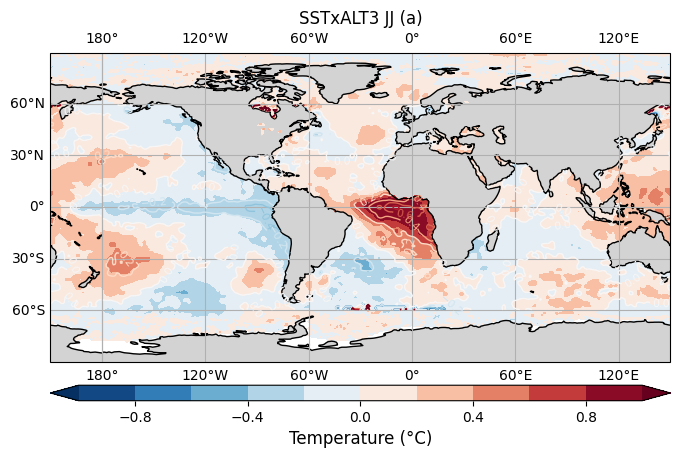

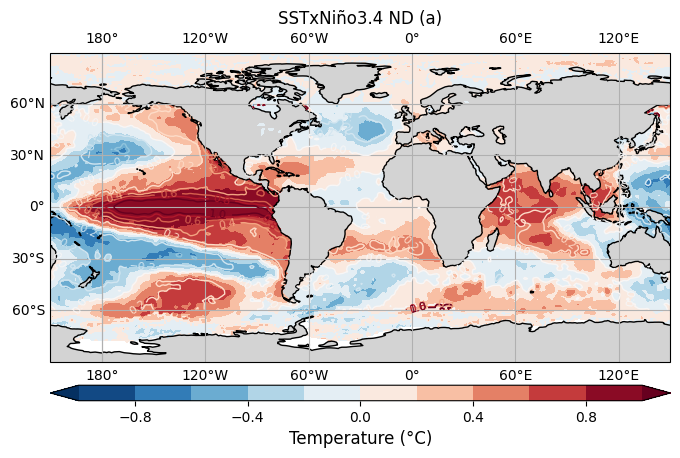

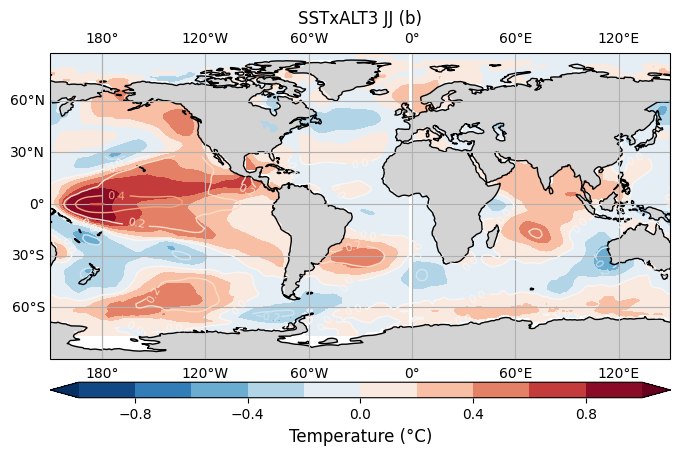

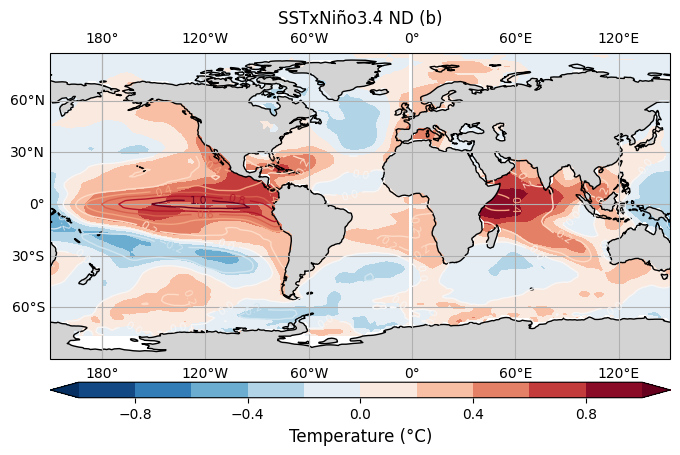

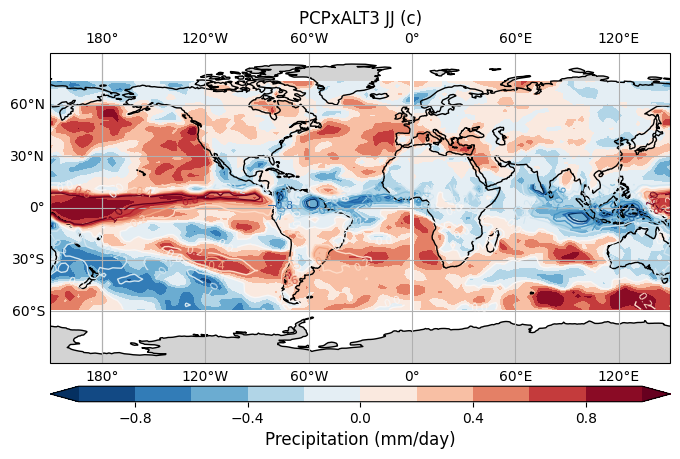

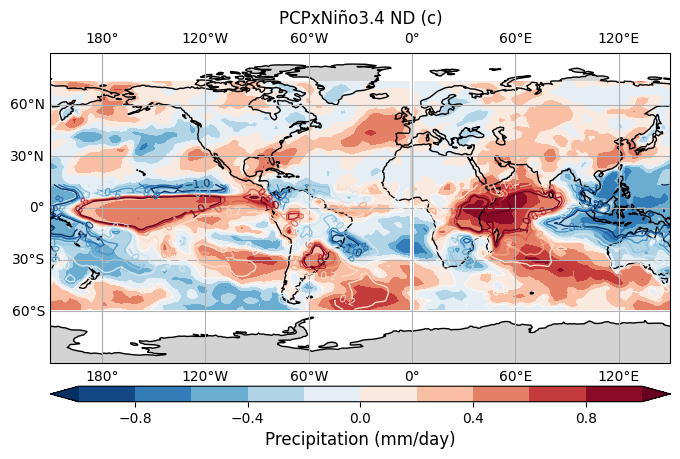

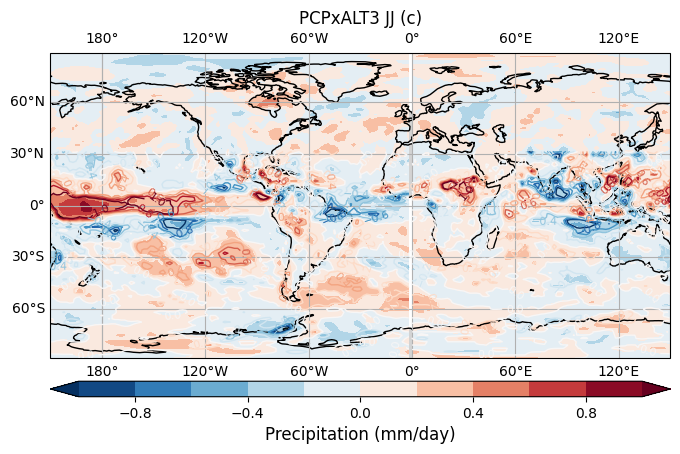

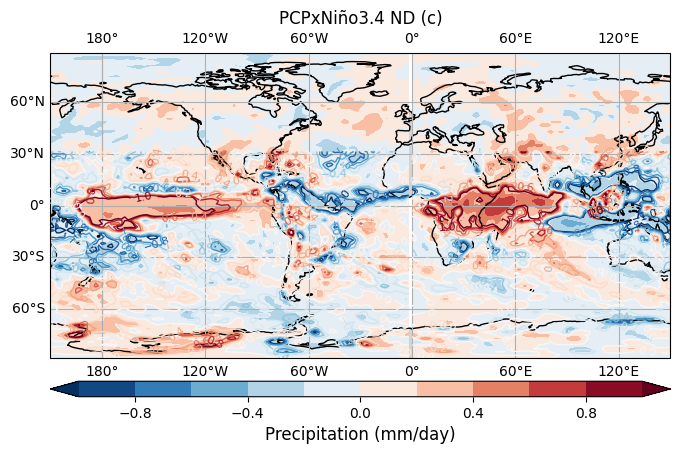

In [29]:
# Configuración común para todas las figuras
def configure_plot(ax, title, cb_label, data_type='temp'):
    """Configuración común para todos los plots"""
    # Estilo del mapa
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.gridlines(draw_labels=True)
    
    # Configuración de la barra de color
    cmap = plt.cm.RdBu_r
    clev = np.linspace(-1, 1, 11)
    
    return cmap, clev

# Función para crear plots individuales
def create_plot(lon, lat, slope_data, corr_data, title, cb_label, data_type='temp'):
    fig, ax = plt.subplots(figsize=(8, 6), 
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=330)})
    
    cmap, clev = configure_plot(ax, title, cb_label, data_type)
    
    # Contornos de pendiente
    cont = ax.contour(lon, lat[30:150], slope_data[30:150], clev, 
                     transform=ccrs.PlateCarree(), cmap=cmap, linewidths=1)
    plt.clabel(cont, inline=True, fontsize=8)
    
    # Relleno de correlación
    fill = ax.contourf(lon, lat, corr_data, clev,
                      transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
    
    # Barra de color
    cb = plt.colorbar(fill, orientation='horizontal', pad=0.05, aspect=40)
    cb.set_label(cb_label, fontsize=12)
    
    plt.title(title, fontsize=12)
    plt.show()

# Ahora creamos todos los plots de manera consistente:

# Datos de temperatura (a y b)
create_plot(lon_a, lat_a, a_HADISST_ATL3, corr_HADISST_ATL3,
           'SSTxALT3 JJ (a)', 'Temperature (°C)')
create_plot(lon_a, lat_a, a_HADISST_NIÑO, corr_HADISST_NIÑO,
           'SSTxNiño3.4 ND (a)', 'Temperature (°C)')

create_plot(lon_b, lat_b, a_mmean_ATL3, corr_mmean_ATL3,
           'SSTxALT3 JJ (b)', 'Temperature (°C)')
create_plot(lon_b, lat_b, a_mmean_NIÑO, corr_mmean_NIÑO,
           'SSTxNiño3.4 ND (b)', 'Temperature (°C)')

# Datos de precipitación (c)
create_plot(lon_pcp, lat_pcp, a_pcp_ATL3, corr_pcp_ATL3,
           'PCPxALT3 JJ (c)', 'Precipitation (mm/day)', 'precip')
create_plot(lon_pcp, lat_pcp, a_pcp_NIÑO, corr_pcp_NIÑO,
           'PCPxNiño3.4 ND (c)', 'Precipitation (mm/day)', 'precip')

create_plot(lon_pcp2, lat_pcp2, a_pcp2_ATL3, corr_pcp2_ATL3,
           'PCPxALT3 JJ (c)', 'Precipitation (mm/day)', 'precip')
create_plot(lon_pcp2, lat_pcp2, a_pcp2_NIÑO, corr_pcp2_NIÑO,
           'PCPxNiño3.4 ND (c)', 'Precipitation (mm/day)', 'precip')